**30E03500 - Data Science for Business II (2019)**

# Tutorial 1: Forecasting Brazilian Inflation 

## Introduction

### The challenge of inflation forecasting

* Forecasting inflation in real-time is difficult and has been studied extensively in the literature.
* Garcia et al. show that high-dimensional econometric models, such as shrinkage and complete subset regression, perform very well in the real-time forecasting of inflation in data-rich environments
* In this exercise, we consider a direct forecast approach where the inflation $h$ periods ahead, $\pi_{t+h}$, is modeled as a function of a set of predictors measured at time $t$, such that $$
\pi_{t+h}=T(\mathbf{x}_t) + u_{t+h},
$$

    where $T(\mathbf{x}_t)$ is a possibly non-linear mapping of a set of $q$ predictors, $u_{t+h}$ is the forecasting error, and $\mathbf{x}_t=(x_{1t},\dots,x_{qt})\in \mathbb{R}^q$ may include weakly exogenous variables, lagged values of inflation, and factors computed from a large number of potential covariates.
* For the purpose of this tutorial, we can assume that $T$ is a simple linear mapping, i.e.,$$
\pi_{t+h}=\mathbf{\beta}'\mathbf{x}_t + u_{t+h} = \sum_{i=1}^q \beta_{it}x_{it} + u_{t+h},
$$

    where $\mathbf{\beta}\in\mathbb{R}^q$ is a vector of unknown parameters.


### Brazil CPI Index dataset

**Source**: M.G.P. Garcia et al. (2017): Real-time inflation forecasting with high-dimensional models: The case of Brazil. *International Journal of Forecasting*, 33, pp. 679-693.

<img src="Images/macro-variables.png" width="900">
<img src="Images/expectation-variables.png" width="500">




## Import libraries

In [117]:
import pandas as pd #data frames (for storing data)
import numpy as np #scientific computing
import time

import matplotlib.pyplot as plt
import seaborn as sns

#TS plots
import scipy.stats as scs

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

## Load data

We provide a number of hints to ensure the data is loaded as a Series:

- `header=0`: We must specify the header information at row 0.
- `parse_dates=[0]`: We give the function a hint that data in the first column contains dates that need to be parsed. This argument takes a list, so we provide it a list of one element, which is the index of the first column.
- `index_col=0`: We hint that the first column contains the index information for the time series.
- `squeeze=True`: We hint that we only have one data column and that we are interested in a Series and not a DataFrame.

In [118]:
brazil = pd.read_csv('brazil_dataset.txt', header=0, parse_dates=[0], index_col=0, squeeze=True)

In [119]:
brazil.tail().style

In [120]:
brazil.shape

(156, 92)

## Plot time series of target

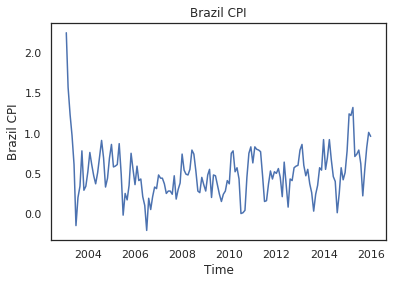

In [121]:
# check the target variable time series
plt.plot(brazil['Brazil CPI IPCA MoM'])
plt.title('Brazil CPI')
plt.xlabel('Time')
plt.ylabel('Brazil CPI')
plt.show()

## Plot correlations with other variables

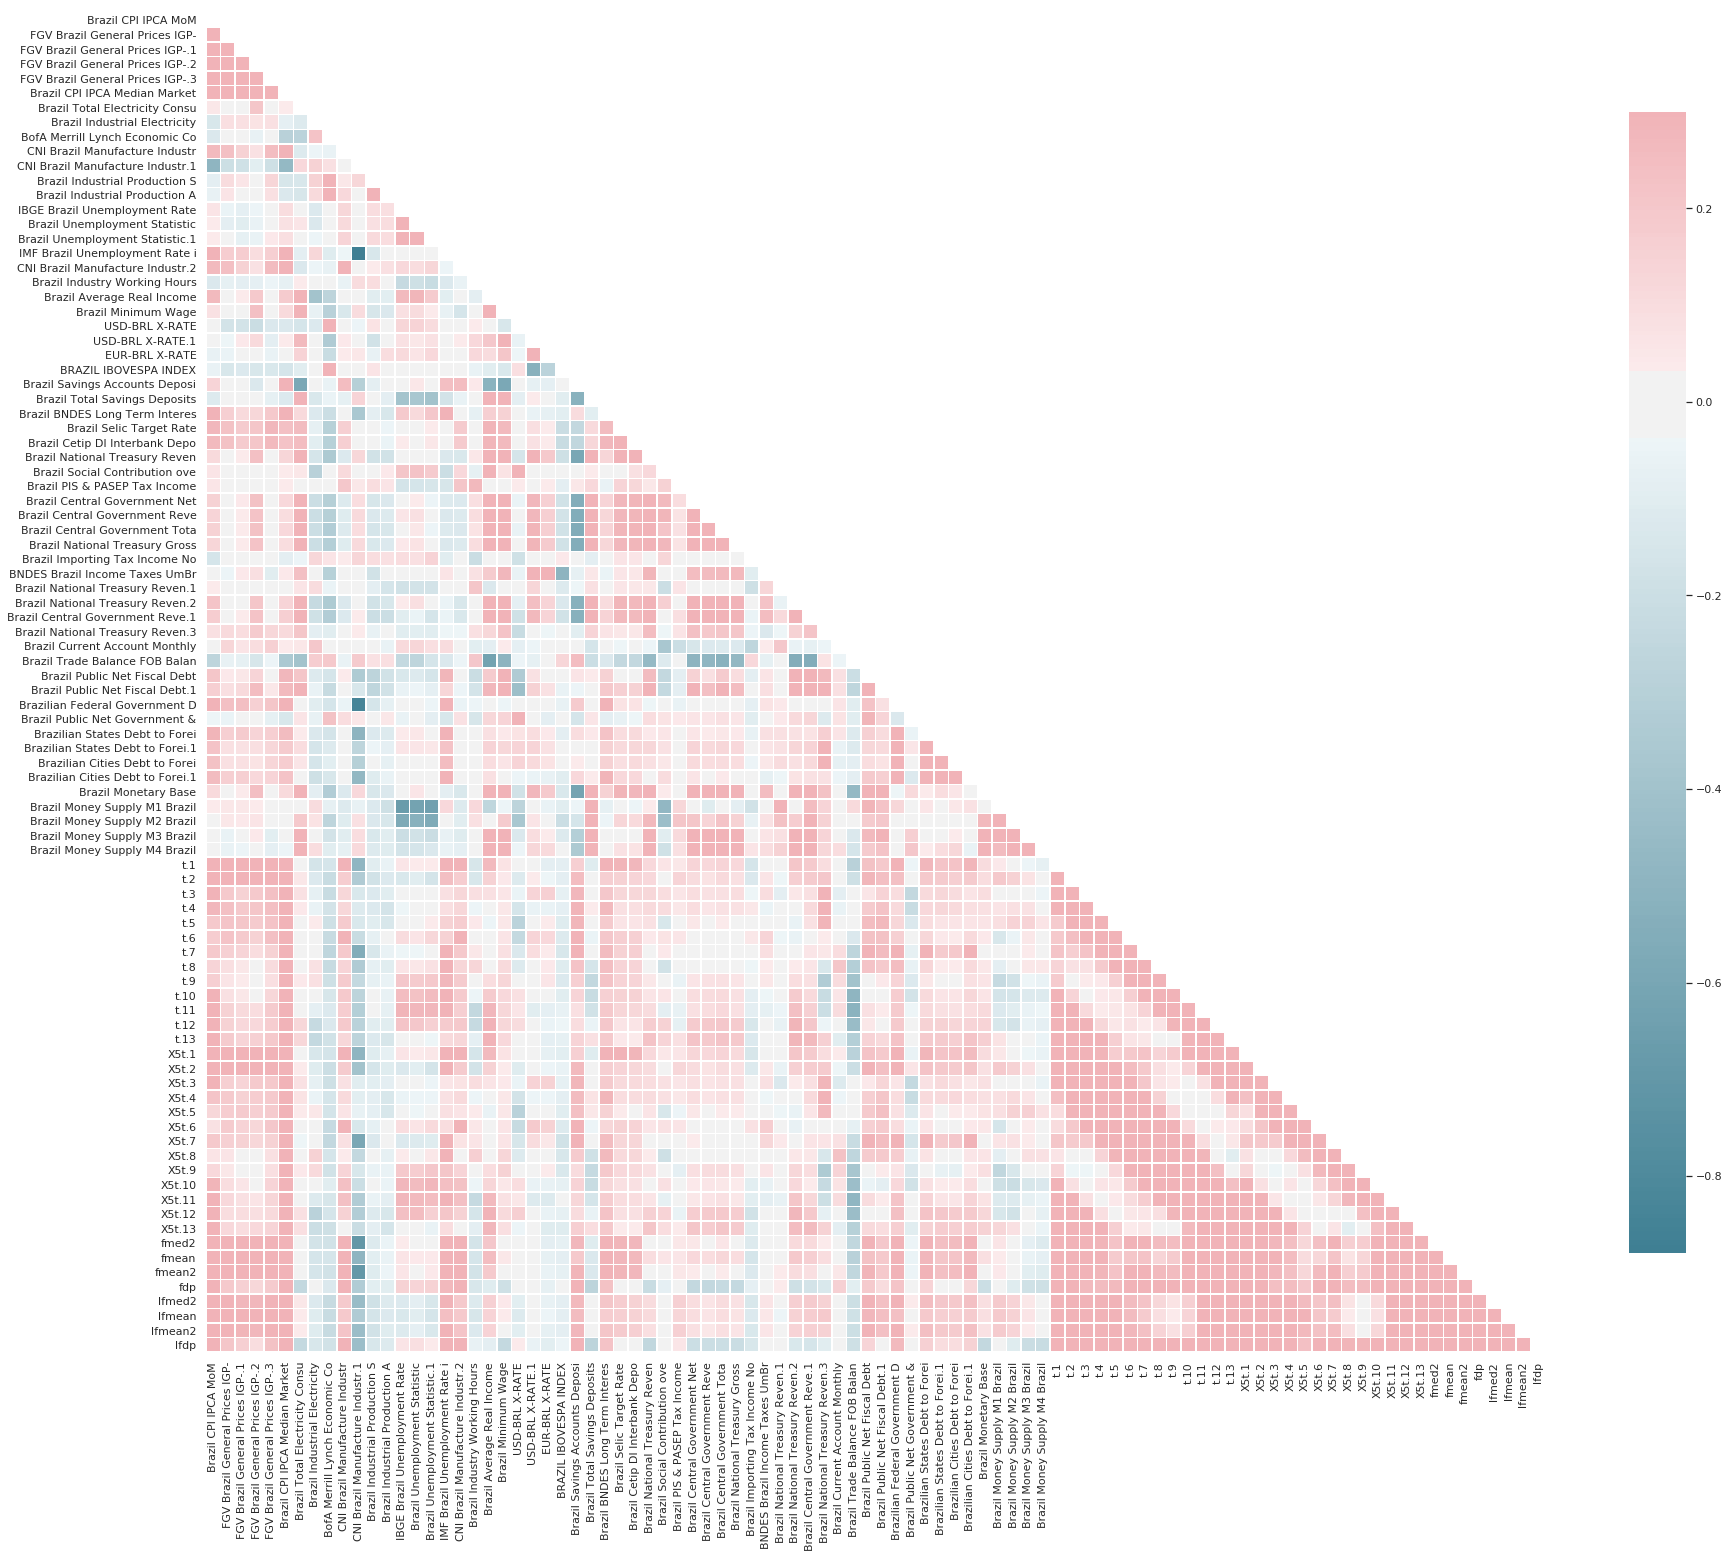

In [122]:
sns.set(style="white")

# Compute the correlation matrix
corr = brazil.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7});

## Fundamentals of time series analysis

Python has a number of packages devoted to time series analysis. However, to keep things simple, we will not use them, since many of the proposed packages are not meant to be used when you are considering a very large number of explanatory variables. Also, some of them are very much black-box in character, and, therefore, it may be good to try and build the models around basic regressions that make it easy to extend the analysis with tools such as Lasso.

### Simple autoregressive modeling: AR(p) models

One of the basic workhorse models for time series is the auto-regressive (AR) model:
$$
\pi_{t}=c+ \sum_{i=1}^p \phi_i \pi_{t-p} + \epsilon_t
$$


In [123]:
#define embedding function

def embed(data, lag, var_name):
    embedded = data.rename(var_name)
    for i in range(1,lag+1):
        embedded = pd.concat([embedded, data.shift(i).rename(var_name+'_'+str(i))], axis=1)
    
    return embedded[lag::] 

In [124]:
lag = 3
dat = embed(brazil['Brazil CPI IPCA MoM'], lag, var_name='CPI')

In [125]:
ar1 = smf.ols(formula='CPI ~ CPI_1', data=dat).fit()
ar2 = smf.ols(formula='CPI ~ CPI_1 + CPI_2', data=dat).fit()
ar3 = smf.ols(formula='CPI ~ CPI_1 + CPI_2 + CPI_3', data=dat).fit()

### A brief note on stationarity

* **Stationary process** is the one which generates time-series values such that distribution mean and variance are kept constant. Strictly speaking, this is known as *weak form of stationarity* or *covariance/mean stationarity*. Weak form of stationarity is when the time-series has constant mean and variance throughout the time period.

* Since stationarity is an assumption underlying many statistical procedures used in time-series analysis, **non-stationary data is often transformed to become stationary** (e.g., by differencing or removing an underlying trend).

* Common causes for violation of stationarity:
     - unit root in mean: stochastic shocks have permanent effects, and the process is not mean-reverting (e.g., random walk);
     - trend: stochastic shocks have transitory effects after which the variable tends toward a deterministically evolving (non-constant) mean.
      
* One of the ways for identifying non-stationary time series is the autocorrelation (ACF) plot. For a stationary time series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly.

### Autocorrelation plots

In [126]:
def tsplot(y, lags=None, figsize=(12, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

Consider the plots for the original series:

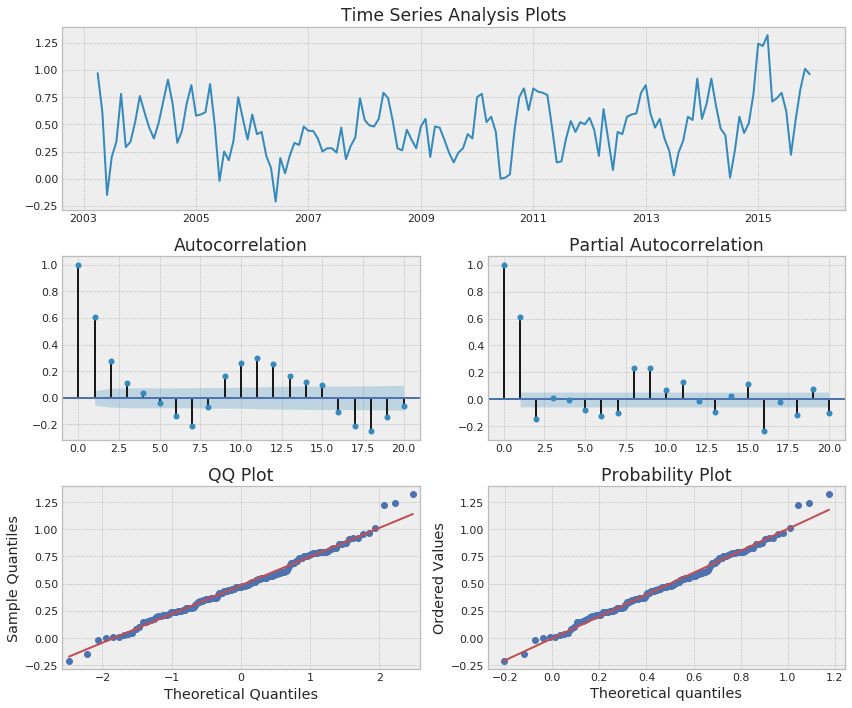

In [127]:
tsplot(dat['CPI'], lags=20)

Consider the plots for the residuals of AR(1) model:

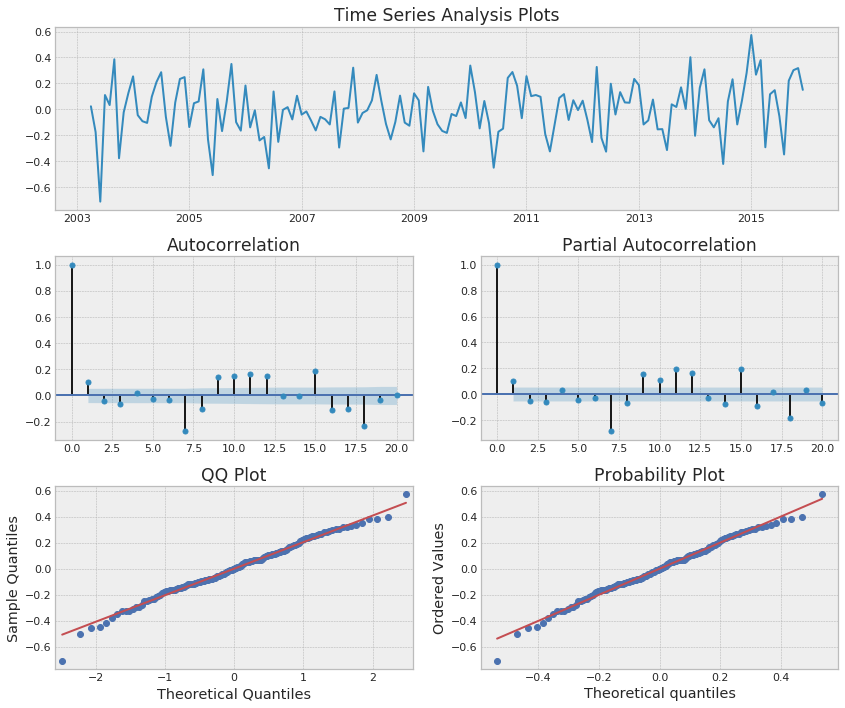

In [128]:
tsplot(ar1.resid, lags=20)

### Use AR(1) model to simulate realizations and compare to known non-stationary process


In [129]:
# Simulating observations from AR(1) model

const = ar1.params[0] #intercept
phi = ar1.params[1] 
sigma = np.sqrt(ar1.scale) #residual standard error is obtained in Python via sqrt(scale)
y_0 = dat.iloc[0]['CPI']
N = 97

def simulate_from_ar1(const, phi, sigma, N, initial_value = 0.0):
    N = dat.shape[0] #number of rows
    y = np.zeros(dat.shape[0]) 
    e = np.random.normal(size=N, scale=sigma)
    y[0] = initial_value
    for t in range(1,N): 
        y[t] = const + phi*y[t-1] + e[t] #linear regresssion!
    return y

In [130]:
sim1 = simulate_from_ar1(const, phi, sigma, N, y_0)
sim2 = simulate_from_ar1(const, 1, 3*sigma, N, y_0)

In [131]:
def tsplot_comp(y1,y2, lags=None, figsize=(16, 10), style='bmh'):
    if not isinstance(y1, pd.Series):
        y1 = pd.Series(y1)
    if not isinstance(y2, pd.Series):
        y2 = pd.Series(y2)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (2, 2)
        ts1_ax = plt.subplot2grid(layout, (0, 0))
        ts2_ax = plt.subplot2grid(layout, (1, 0))
        acf1_ax = plt.subplot2grid(layout, (0, 1))
        acf2_ax = plt.subplot2grid(layout, (1, 1))      
        
        y1.plot(ax=ts1_ax, title='Simulated AR(1) trajectory w/o unit root')
        y2.plot(ax=ts2_ax, title='Simulated AR(1) trajectory with unit root')
        smt.graphics.plot_acf(y1, lags=lags, ax=acf1_ax, alpha=0.5)
        smt.graphics.plot_acf(y2, lags=lags, ax=acf2_ax, alpha=0.5) 
        
        plt.tight_layout()
    return     

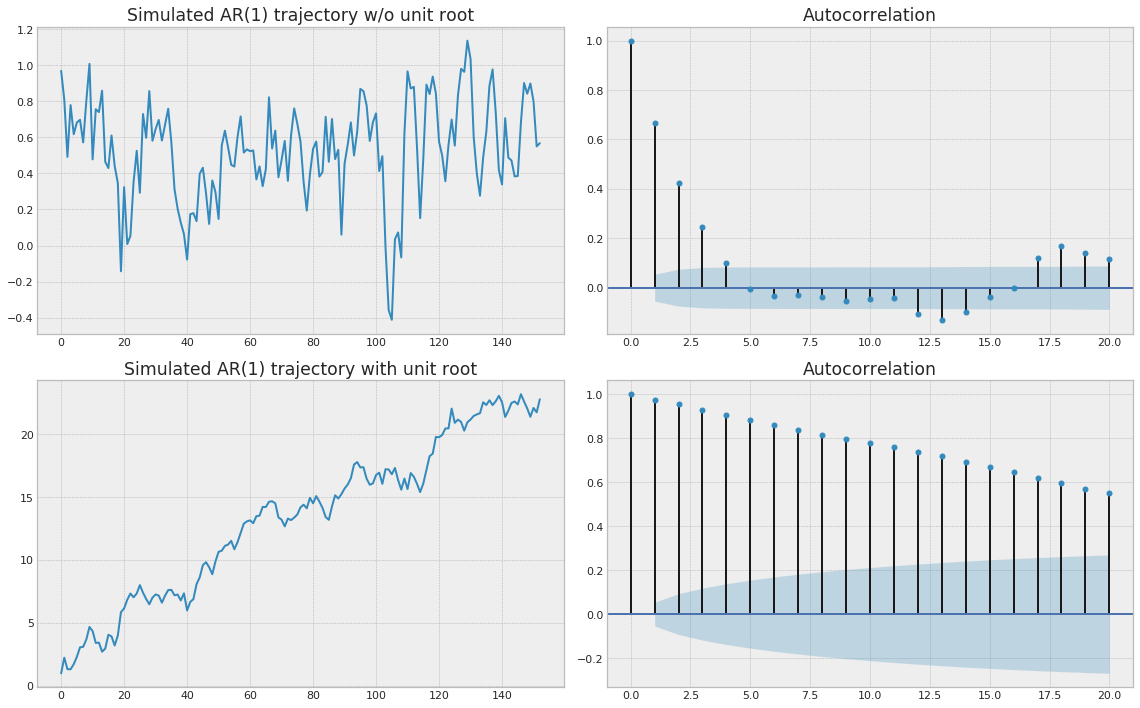

In [132]:
tsplot_comp(sim1, sim2, lags=20)

## Using Lasso with time series data

Now we are ready to look at a more complicated model, which includes also other variables than the lagged values of the target variable. Here we will consider as **explanatory variables the lags of all variables available in the Brazil inflation dataset.**

The LASSO estimator is given by 

$$
\hat{\mathbf{\beta}} = \text{argmin}_{\beta} \left[ \sum_{t=1}^T (\pi_{t+h} - \mathbf{\beta}'\mathbf{x}_t)^2 + \lambda\sum_{j=1}^q |\beta_j| \right] .
$$

### Import Lasso libraries

In [133]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale 

### Prepare dataset for Lasso 

The original dataset contains the current values of all the variables. To perform regression on lagged values, we must derive the lag-variables first:
- lag ("shift") all explanatory variables by 1
- mark them with a `_lag1` suffix
- remove the 1st line **from the explanatory variables** (not the target)

We also need to divide the data into in-sample and out-of-sample datasets.



In [134]:
lag = 1
data = brazil.shift(lag).add_suffix('_lag1')[lag::]
data.shape

(155, 92)

Define the target variable

In [135]:
y = brazil['Brazil CPI IPCA MoM'][lag::].values

Define insample / outsample data. The order matters in time-series data. Thus, <font color='red'>**we cannot perform a random train/test split.**</font> Instead, we select the first 100 observations for training and the remaining (55) observations for testing.

In [136]:
X_train, y_train = data[0:100], y[0:100]
X_test, y_test = data[100:], y[100:]

### Estimate Lasso regression for inflation

Visualize different lambda regularization values (alpha in Python):

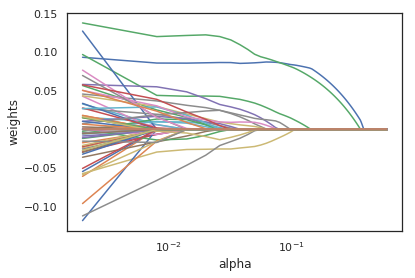

In [137]:
alphas= np.linspace(0.3, 0.001, 100) #array of 100 lambda values between 0.3 and 0.001
model = Lasso(max_iter = 10000, normalize = False)
coefs = []

for a in alphas:
    model.set_params(alpha=a)
    model.fit(scale(X_train.astype(float)), y_train)
    coefs.append(model.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights');

### How to find the optimal regularization parameter?

Normally, we try to choose this using cross-validation (`LassoCV` sklearn package). In general, with time series models, this should not be done. The data shouldn't be shuffled randomly. Why? 

A better strategy would be to consider using information criteria computed along the regularization paths. The sklearn package `LassoLarsIC` (IC for Information Criteria) can be used to find the optimal regularization parameter using BIC and AIC. 

In [138]:
from sklearn.linear_model import LassoLarsIC

In [139]:
model_bic = LassoLarsIC(criterion='bic', normalize=True, max_iter=10000)
t1 = time.time()
model_bic.fit(X_train, y_train)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic', normalize=True, max_iter=10000)
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.alpha_

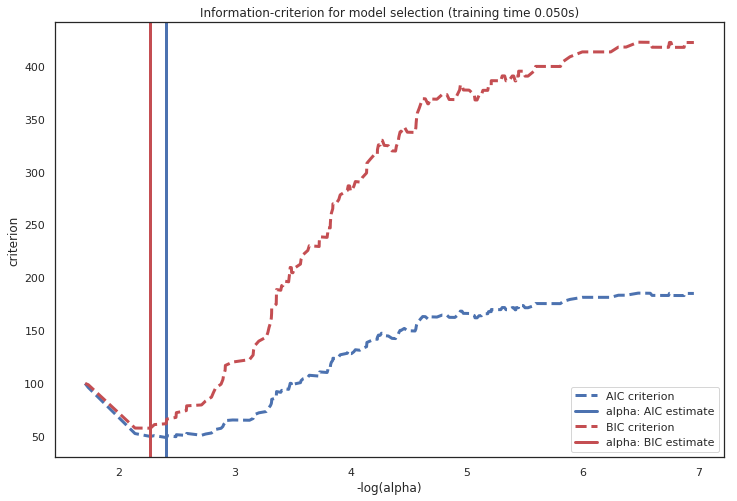

In [140]:
def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure(figsize=(12,8))
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'% t_bic);

### What variables have been selected in the model? What is the optimal lambda (alpha) value?

Based on **BIC**:

In [141]:
bic_features = pd.Series(model_bic.coef_, index=brazil.columns)
print(bic_features.iloc[bic_features.nonzero()[0]])
print('\nOptimal BIC lambda: ' + str(alpha_bic_))

Brazil CPI IPCA MoM                 0.255166
FGV Brazil General Prices IGP-.1    0.019412
X5t.2                               0.404708
dtype: float64

Optimal BIC lambda: 0.005323667802278892


Based on **AIC**:

In [142]:
aic_features = pd.Series(model_aic.coef_, index=brazil.columns)
print(aic_features.iloc[aic_features.nonzero()[0]])
print('\nOptimal AIC lambda: ' + str(alpha_aic_))

Brazil CPI IPCA MoM                 0.265405
FGV Brazil General Prices IGP-.1    0.033562
Brazil Industry Working Hours      -0.009371
Brazil Money Supply M4 Brazil       0.000610
X5t.2                               0.444220
dtype: float64

Optimal AIC lambda: 0.003899230126458309


### Predicting with Lasso and AR(1) models

Define a Lasso model with the optimal lambda (alpha) value:

In [143]:
# compute lasso result
lasso = Lasso(max_iter = 10000, normalize = True, alpha= 0.003899230126458309) #0.01943376 in R, but needs one more 0 in Python
lasso.fit(X_train, y_train)

Lasso(alpha=0.003899230126458309, copy_X=True, fit_intercept=True,
   max_iter=10000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [144]:
y_pred_lasso = lasso.predict(X_test)
y_pred_lasso

array([0.24645991, 0.23514261, 0.27160784, 0.42785551, 0.5065402 ,
       0.47767124, 0.51894277, 0.47897692, 0.55912271, 0.44663284,
       0.46326232, 0.56922156, 0.35756606, 0.26647051, 0.42435408,
       0.47586796, 0.55441757, 0.4768603 , 0.55540583, 0.67371921,
       0.52581114, 0.47242254, 0.44615657, 0.41854829, 0.35066873,
       0.32236907, 0.23038007, 0.40054185, 0.50318623, 0.5939177 ,
       0.60510011, 0.69373645, 0.59383311, 0.57268929, 0.75208693,
       0.53639715, 0.37114886, 0.33589479, 0.21647674, 0.39627872,
       0.53157689, 0.50987677, 0.68445651, 0.77487095, 0.92015735,
       0.94172426, 0.78589606, 0.59104672, 0.48342732, 0.587034  ,
       0.41499242, 0.34025042, 0.57614581, 0.65583936, 0.90906519])

Define data for AR1 model

In [145]:
y_AR1 = y_train #same target
X_train_AR1 = X_train['Brazil CPI IPCA MoM_lag1'].rename('CPI_1') #only 1 feature
X_test_AR1 = X_test['Brazil CPI IPCA MoM_lag1'].rename('CPI_1')

In [146]:
AR1_data = pd.DataFrame(X_train_AR1)
AR1_data['CPI'] = y_AR1

Compute AR1 model

In [147]:
ar1 = smf.ols(formula='CPI ~ CPI_1', data=AR1_data).fit()

Predict with AR1 model

In [148]:
y_pred_AR1 = ar1.predict(X_test_AR1)

Combine Lasso and AR1 predictions in a dataframe

In [149]:
pred_df = pd.DataFrame(y_pred_AR1.rename('y_pred_AR1'))
pred_df['y_pred_lasso'] = y_pred_lasso
pred_df['y_test'] = y_test
pred_df.head()

y_pred_AR1  y_pred_lasso  y_test
2011-06-30    0.457270      0.246460    0.15
2011-07-31    0.267051      0.235143    0.16
2011-08-31    0.272995      0.271608    0.37
2011-09-30    0.397826      0.427856    0.53
2011-10-31    0.492936      0.506540    0.43

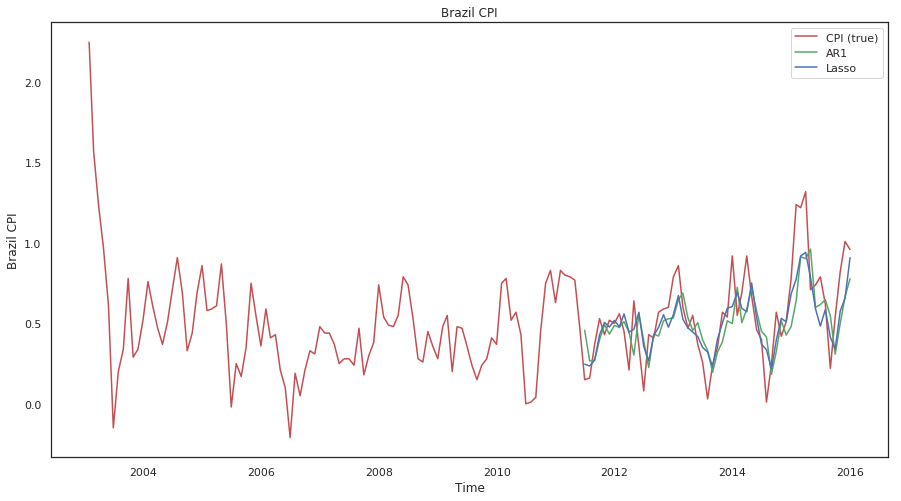

In [150]:
# plot comparison against realized values

plt.figure(figsize=(15,8))
plt.plot(brazil['Brazil CPI IPCA MoM'], label='CPI (true)', c='r')

plt.plot(pred_df['y_pred_AR1'], label='AR1', c='g')
plt.plot(pred_df['y_pred_lasso'], label='Lasso', c='b')
plt.title('Brazil CPI')
plt.xlabel('Time')
plt.ylabel('Brazil CPI')

plt.legend()
plt.show()

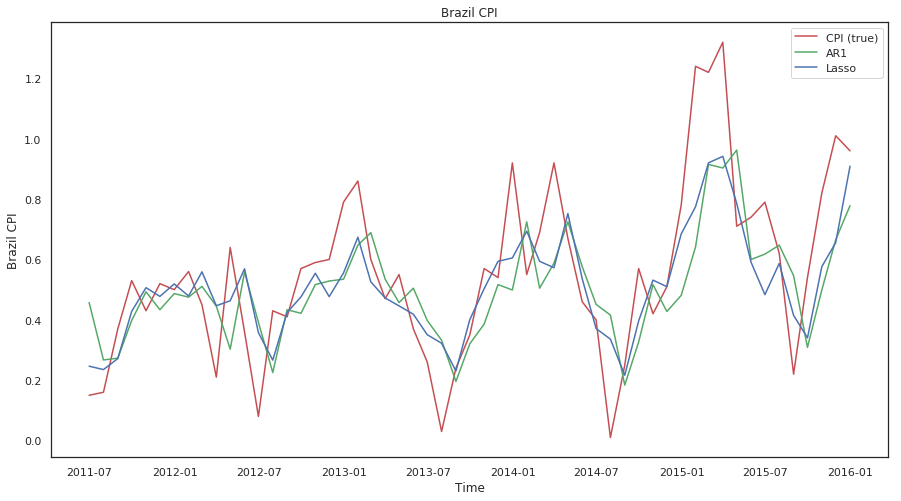

In [151]:
# plot comparison against realized values

plt.figure(figsize=(15,8))
plt.plot(pred_df['y_test'], label='CPI (true)', c='r')
plt.plot(pred_df['y_pred_AR1'], label='AR1', c='g')
plt.plot(pred_df['y_pred_lasso'], label='Lasso', c='b')
plt.title('Brazil CPI')
plt.xlabel('Time')
plt.ylabel('Brazil CPI')

plt.legend()
plt.show()

In [152]:
# compare RMSE scores
print('Lasso RMSE: ' + str(np.sqrt(np.mean((y_test - y_pred_lasso)**2))))
print('AR1 RMSE: ' + str(np.sqrt(np.mean((y_test - y_pred_AR1)**2))))

Lasso RMSE: 0.1806001256584719
AR1 RMSE: 0.22123719189925103


### Final note

Although `LassoLarsIC` did help in finding an optimal lambda value, the R package `ic.glmnet` was able to find a better one that results in a lower RMSE. Thus, there is still room for further optimization. 